In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import pandas as pd
import scipy.io
import json
from scipy.stats import gaussian_kde
from pingouin import ancova
from scipy.stats import entropy, linregress, ks_2samp, chisquare
from model import SequentialPerception, build_network, detect_extrema_sequential

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [2]:
# label = "july1_degrade_acc"
# emp = pd.read_pickle(f"data/forstmann2011.pkl").query("age=='young'")
# dfs = []
# for pid in emp['pid'].unique():
#     df = pd.read_pickle(f"data/forstmann_{pid}_{label}.pkl")
#     df['pid'] = [pid for _ in range(df.shape[0])]
#     dfs.append(df)
# simulated = pd.concat(dfs, ignore_index=True)
# simulated.to_pickle(f"data/forstmann_{label}.pkl")

## Helper Functions

In [3]:
def chi_squared_distance(a,b):
    distance = 0
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    return distance

In [4]:
def get_kde_loss(simulated, empirical, dPs, max_cues):
    loss = 0
    eval_points = np.linspace(0, 2*max_cues, 1000)
    for dP in dPs:
        cues_sim = simulated.query("dP==@dP")['cues'].to_numpy()
        cues_emp = empirical.query("dP==@dP")['cues'].to_numpy()
        # check for zero variance and assign error accordingly
        unique_sim = simulated.query("dP==@dP")['cues'].unique()
        unique_emp = empirical.query("dP==@dP")['cues'].unique()
        if len(unique_sim)==1 or len(unique_emp)==1:
            mean_emp = np.mean(cues_emp)
            mean_sim = np.mean(cues_sim)
            error = np.abs(mean_emp - mean_sim)
        else:
            # assign error normally
            kde_emp = gaussian_kde(cues_emp, bw_method='scott')
            kde_sim = gaussian_kde(cues_sim, bw_method='scott')
            estimate_emp = kde_emp.evaluate(eval_points)
            estimate_sim = kde_sim.evaluate(eval_points)
            estimate_emp = estimate_emp / np.sum(estimate_emp)
            estimate_sim = estimate_sim / np.sum(estimate_sim)
            error = 1000*np.sqrt(np.mean(np.square(estimate_emp - estimate_sim)))
        loss += error
    # print(f"loss {loss}")
    return loss

## Example sequence

In [ ]:
trial_num = 3
max_cues = 12
seed = 0
dP = 0.2
inputs = SequentialPerception(dt_sample=0.1, seed=seed, max_cues=max_cues)
inputs.create(dP=dP)
for cue in range(max_cues):
    print(f"trial {trial_num}, day {cue+1}: L: {inputs.sampled[0][:cue+1].astype(int)}, R {inputs.sampled[1][:cue+1].astype(int)}")
print(f"trial {trial_num}, L rose on {int(np.sum(inputs.sampled[0]))} days, and R rose on {int(np.sum(inputs.sampled[1]))} days, so {'L' if inputs.correct==0 else 'R'} is correct")

# Empirical data from Fiedler 2021

In [5]:
def plot_emp_RTs(max_cues, cue_step, aggregate=True, bw=1, cut=2):
    emp = pd.read_pickle("data/fiedler_trial.pkl").query("max_cues==@max_cues")
    if aggregate:
        fig = sns.FacetGrid(emp, col="dP", sharey='row', col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1.5)
        fig.map_dataframe(sns.histplot, x="cues", kde=True, kde_kws={'bw_adjust': bw, 'cut': cut, 'clip': None},
                          bins=np.arange(0, 2*max_cues+1, 1), common_norm=False)
        fig.set_xlabels("Cues Sampled Per Trial")
        fig.set(xticks=[0,6,12,18,24])
        fig.add_legend()
        fig.savefig(f"plots/fiedler_RTs_{max_cues}.svg")
        fig.savefig(f"plots/fiedler_RTs_{max_cues}.png", dpi=600)
    else:
        # fig = sns.FacetGrid(emp.query("id in @ids"), row="id", col="dP", sharey='row', row_order=ids, col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1.5)
        fig = sns.FacetGrid(emp, row="id", col="dP", sharey='row', col_order=[0.4, 0.2, 0.1], palette=palette, height=1.5, aspect=1.5)
        fig.map_dataframe(sns.histplot, x="cues", kde=True, kde_kws={'bw_adjust': bw, 'cut': cut, 'clip': None}, # [0, 2*max_cues]
                          bins=np.arange(0, 2*max_cues+1, 1), common_norm=False)
        fig.set_xlabels("Cues Sampled Per Trial")
        fig.set(xticks=[0,6,12,18,24])
        fig.add_legend()
        fig.savefig(f"plots/fiedler_RTs_{max_cues}_individual.svg")
        fig.savefig(f"plots/fiedler_RTs_{max_cues}_individual.png", dpi=600)

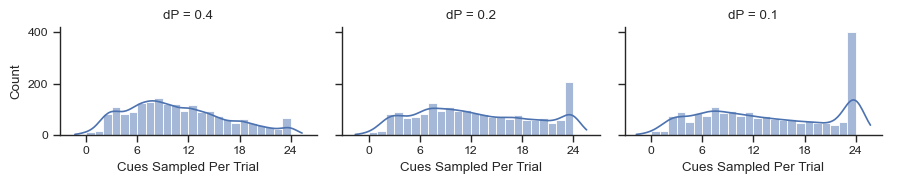

In [106]:
plot_emp_RTs(max_cues=12, cue_step=3, aggregate=True, bw=0.7, cut=1.5)

In [ ]:
plot_emp_RTs(max_cues=12, cue_step=3, aggregate=False, bw=0.7, cut=1.5)

# Neural Network Dynamics

In [6]:
def sequential_trial(dP, ramp=1, threshold=0.4, relative=1, perception_seed=0, network_seed=0, trial=0, amin=0.01,
                 dt=0.001, max_cues=12, dt_sample=0.1, rA=1.0, nNeurons=500, legend=True, name="sequential"):

    inputs = SequentialPerception(dt_sample=dt_sample, seed=perception_seed+int(dP*10), max_cues=max_cues)
    for t in range(trial):
        inputs.create(dP=dP)  # lines up the input rng as though multiple trials had been previously simulated
    inputs.create(dP=dP)
    # print(inputs.Ps, inputs.sampled)
    net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative, rA=rA, nNeurons=nNeurons)
    sim = nengo.Simulator(net, progress_bar=False)
    choice = None
    RT = None
    while choice==None:
        sim.run(dt)
        if np.any(sim.data[net.pAction][-1,:] > amin):
            choice = np.argmax(sim.data[net.pAction][-1,:])
            RT = sim.trange()[-1]
        if sim.trange()[-1] > 2*max_cues*dt_sample-dt:
            choice = np.argmax(sim.data[net.pValue][-1,:])
            RT = sim.trange()[-1]
    correct = 1 if choice==net.inputs.correct else 0
    cues = min(int(RT/dt_sample)+1, 2*max_cues)

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7.08, 3)))
    for a in range(2):
        cue_label = "L" if a==0 else "R"
        axes[0].plot(sim.trange(), sim.data[net.pAccumulator][:,a], color=palette[a], lw=0.5, label=f"Evidence {cue_label}") 
    for a in range(2):
        cue_label = "L" if a==0 else "R"
        axes[0].plot(sim.trange(), np.cumsum(sim.data[net.pInputs][:,a]*dt*ramp), color=palette[a], label=f"True {cue_label}", linestyle="--") 
        axes[1].plot(sim.trange(), sim.data[net.pValue][:,a], color=palette[a], label=f"Value {cue_label}") 
    axes[1].plot(sim.trange(), net.threshold*np.ones_like(sim.trange()), label='Threshold', color="red", linestyle=":")
    axes[0].set(ylabel=r"$\mathbf{\hat{x}}(t)$", xlabel="Time (s)", title="Evidence in Accumulator")
    axes[1].set(xlabel="Time (s)", title="Decision Criteria")
    if legend:
        axes[0].legend(loc='upper left', ncol=2)
        leg = axes[1].legend(loc='upper left')
        leg.get_texts()[choice].set_color("lime" if correct else "red")
    print(f"RT {RT}, cues {cues}, choice {choice}, correct {net.inputs.correct}")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

RT 0.779, cues 8, choice 0, correct 0


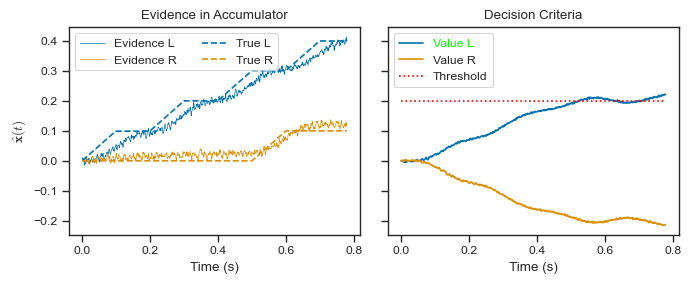

In [19]:
sequential_trial(dP=0.4, ramp=1, threshold=0.2, relative=1, dt_sample=0.1, perception_seed=1)

RT 1.459, cues 15, choice 0, correct 0


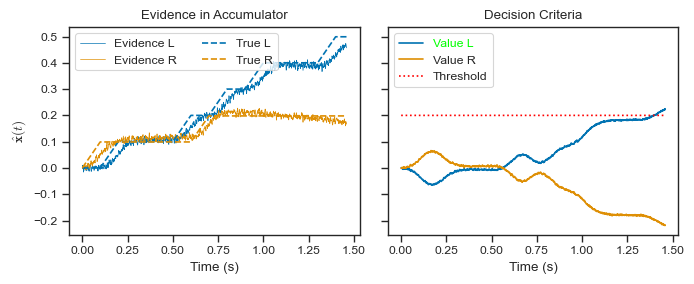

In [30]:
sequential_trial(dP=0.4, ramp=1, threshold=0.2, relative=1, dt_sample=0.1, perception_seed=8)

RT 2.4, cues 24, choice 0, correct 0


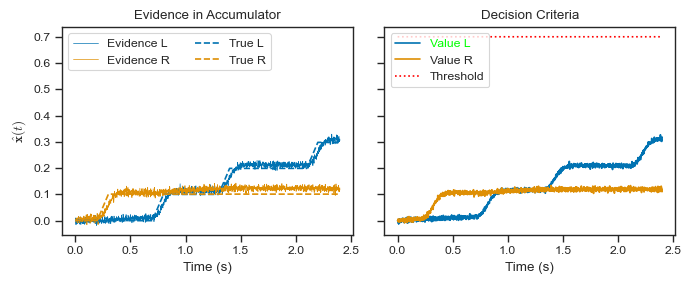

In [56]:
sequential_trial(dP=0.2, ramp=1, threshold=0.7, relative=0.0, dt_sample=0.1, amin=0.01, perception_seed=0)

In [7]:
def double_trial(dP, ramps=[1,1], thresholds=[0.4,0.3], relatives=[1,1], perception_seed=0, network_seed=0, trial=0,
                 dt=0.001, max_cues=12, dt_sample=0.1, rA=1.5, nNeurons=500, legend=True, name="double"):

    fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=((7, 4)))
    for i in range(2):
        ramp, threshold, relative = ramps[i], thresholds[i], relatives[i]
        inputs = SequentialPerception(dt_sample=dt_sample, seed=perception_seed+int(dP*10), max_cues=max_cues)
        for t in range(trial):
            inputs.create(dP=dP)  # lines up the input rng as though multiple trials had been previously simulated
        inputs.create(dP=dP)
        # print(inputs.Ps, inputs.sampled)
        net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative, rA=rA, nNeurons=nNeurons)
        sim = nengo.Simulator(net, progress_bar=False)
        choice = None
        RT = None
        while choice==None:
            sim.run(dt)
            if np.any(sim.data[net.pAction][-1,:] > 0.01):
                choice = np.argmax(sim.data[net.pAction][-1,:])
                RT = sim.trange()[-1]
            if sim.trange()[-1] > 2*max_cues*dt_sample-dt:
                choice = np.argmax(sim.data[net.pValue][-1,:])
                RT = sim.trange()[-1]
        correct = 1 if choice==net.inputs.correct else 0
        cues = min(int(RT/dt_sample)+1, 2*max_cues)
        print(f"RT {RT}, cues {cues}, choice {choice}, correct {net.inputs.correct}")
    
        for a in range(2):
            axes[i][0].plot(sim.trange(), sim.data[net.pAccumulator][:,a], color=palette[a], lw=0.5, label=f"Model {i}") 
        for a in range(2):
            axes[i][1].plot(sim.trange(), sim.data[net.pValue][:,a], color=palette[a]) 
        axes[i][1].plot(sim.trange(), net.threshold*np.ones_like(sim.trange()), label=r'T {i}', color="red", linestyle=":")
        for a in range(2):
            axes[i][0].plot(sim.trange(), np.cumsum(sim.data[net.pInputs][:,a]*dt*ramp), color=palette[a], label=f"True {a}", linestyle="--") 
    axes[0][0].set(ylabel=r"$\mathbf{\hat{x}}(t)$", title="Cumulative Evidence, "+r"$R=$"+f"{ramps[0]}")
    axes[1][0].set(ylabel=r"$\mathbf{\hat{x}}(t)$", xlabel="Time (s)", title="Cumulative Evidence, "+r"$R=$"+f"{ramps[1]}")
    axes[0][1].set(title="Value, "+r"$T=$"+f"{thresholds[0]}")
    axes[1][1].set(xlabel="Time (s)", title="Value, "+r"$T=$"+f"{thresholds[1]}")
    axes[1][1].xaxis.set_minor_locator(MultipleLocator(dt_sample))
    # axes[0][0].legend(loc='upper left', ncol=3)
    # axes[0][1].legend(loc='upper left', ncol=2)
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

RT 0.35100000000000003, cues 4, choice 1, correct 0
RT 2.273, cues 23, choice 0, correct 0


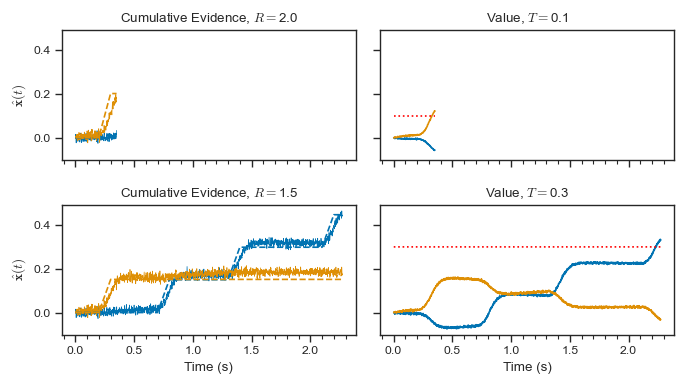

In [32]:
double_trial(dP=0.2, ramps=[2.0, 1.5], thresholds=[0.1, 0.3], relatives=[0.5, 0.5])

# Non-integration Models

In [8]:
def run_all_extrema(dPs=[0.4, 0.2, 0.1], experiment_time=60, dt_sample=0.1,
                    cluster_size=3, positive_only=True, seed=0, perception_seed=0, label='default'):
    columns1 = ['type', 'tid', 'difficulty', 'trial', 'position', 'cue', 'value', 'fraction_sampled', 'sampled_cues', 'max_cues', 
            'chosen', 'target', 'accuracy', 'cue_choice_aligned']
    columns2 = ['type', 'tid', 'dP', 'trial', 'accuracy', 'cues', 'max_cues']
    dfs1 = []
    dfs2 = []
    tid = 0
    for cluster_size in np.arange(1, 10, 1):
        for positive_only in [True, False]:
            for tiebreaker in ['largest']:  # , ['random', 'largest']:
                tid += 1
                print(f"tid {tid}, cluster size {cluster_size}, consider only positive values {positive_only}, break ties {tiebreaker}")
                for max_cues in [12, 18]:
                    for dP in dPs:
                        if dP==0.4: difficulty = 'easy'
                        if dP==0.2: difficulty = 'moderate'
                        if dP==0.1: difficulty = 'hard'
                        inputs = SequentialPerception(seed=perception_seed+int(dP*10), max_cues=max_cues)
                        total_time = 0
                        trial = 0
                        while total_time < experiment_time:
                            inputs.create(dP=dP)
                            cues, accuracy, chosen = detect_extrema_sequential(
                                inputs, cluster_size=cluster_size, positive_only=positive_only, tiebreaker=tiebreaker, seed=seed)
                            # add position data
                            target = "L" if inputs.correct==0 else "R"
                            first = "L" if inputs.first==0 else "R"
                            Ls = inputs.sampled[0]
                            Rs = inputs.sampled[1]
                            for p in range(cues):
                                if first=="L":
                                    cue = 'L' if (p % 2 == 0) else 'R'
                                elif first=="R":
                                    cue = 'R' if (p % 2 == 0) else 'L'                                    
                                if cue == 'R':
                                    value = Rs[int(p/2)]
                                elif cue == 'L':
                                    value = Ls[int(p/2)]
                                fraction_sampled = (p+1) / cues
                                cue_choice_aligned = 0.0
                                if chosen=='R':
                                    if (cue=='R' and value==1) or (cue=='L' and value==0):
                                        cue_choice_aligned += 1
                                    else:
                                        cue_choice_aligned += -1
                                elif chosen=='L':
                                    if (cue=='L' and value==1) or (cue=='R' and value==0):
                                        cue_choice_aligned += 1
                                    else:
                                        cue_choice_aligned += -1
                                df1 = pd.DataFrame([[
                                    'extrema', tid, difficulty, trial, p, cue, value, fraction_sampled, cues, max_cues,
                                    chosen, target, accuracy, cue_choice_aligned
                                    ]], columns=columns1)
                                dfs1.append(df1)
                            # add trial data
                            dfs2.append(pd.DataFrame([['extrema', tid, dP, trial, 100*accuracy, cues, max_cues]], columns=columns2))
                            RT = cues * dt_sample
                            total_time += RT
                            trial += 1

    sim1 = pd.concat(dfs1, ignore_index=True)
    sim2 = pd.concat(dfs2, ignore_index=True)
    sim1.to_pickle(f"data/extrema_position.pkl")
    # sim2.to_pickle(f"data/extrema_trial.pkl")
    sim2.to_pickle(f"data/{label}.pkl")

In [27]:
run_all_extrema(experiment_time=500, label="july11extrema")

tid 1, cluster size 1, consider only positive values True, break ties largest
tid 2, cluster size 1, consider only positive values False, break ties largest
tid 3, cluster size 2, consider only positive values True, break ties largest
tid 4, cluster size 2, consider only positive values False, break ties largest
tid 5, cluster size 3, consider only positive values True, break ties largest
tid 6, cluster size 3, consider only positive values False, break ties largest
tid 7, cluster size 4, consider only positive values True, break ties largest
tid 8, cluster size 4, consider only positive values False, break ties largest
tid 9, cluster size 5, consider only positive values True, break ties largest
tid 10, cluster size 5, consider only positive values False, break ties largest
tid 11, cluster size 6, consider only positive values True, break ties largest
tid 12, cluster size 6, consider only positive values False, break ties largest
tid 13, cluster size 7, consider only positive values T

In [9]:
def fit_extrema_to_fiedler(targeted_dPs=[0.2], max_cues=12, label='default'):
    pd.options.mode.chained_assignment = None
    extr_position = pd.read_pickle(f"data/extrema_position.pkl")
    extr_trial = pd.read_pickle(f"data/{label}.pkl")
    emp_position = pd.read_pickle(f"data/fiedler_position.pkl")
    emp_trial = pd.read_pickle(f"data/fiedler_trial.pkl")
    dfs1 = []
    dfs2 = []
    for pid in emp_trial['pid'].unique():
        empirical = emp_trial.query('pid==@pid & max_cues==@max_cues & dP in @targeted_dPs')
        losses = []
        for sid in extr_trial['tid'].unique():
            simulated = extr_trial.query('tid==@sid & max_cues==@max_cues & dP in @targeted_dPs')
            loss = get_kde_loss(simulated, empirical, targeted_dPs, max_cues)
            losses.append(loss)
        best_tid = extr_trial['tid'].unique()[np.argmin(losses)]
        new_extr_position = extr_position.query("tid==@best_tid")
        new_extr_trial = extr_trial.query("tid==@best_tid")
        emp_id = empirical['id'].unique()[0]
        id_array_size_position = new_extr_position['tid'].to_numpy().shape[0]
        id_array_size_trial = new_extr_trial['tid'].to_numpy().shape[0]
        new_extr_position['id'] = emp_id * np.ones(id_array_size_position)
        new_extr_trial['id'] = emp_id * np.ones(id_array_size_trial)
        dfs1.append(new_extr_position)
        dfs2.append(new_extr_trial)
    extr_position_fit = pd.concat(dfs1, ignore_index=True)
    extr_trial_fit = pd.concat(dfs2, ignore_index=True)
    extr_position_fit.to_pickle(f"data/extrema_position_fit.pkl")
    extr_trial_fit.to_pickle(f"data/{label}_fit.pkl")

In [39]:
fit_extrema_to_fiedler(max_cues=12, label='july11extrema')

In [106]:
# pd.read_pickle(f"data/extrema_trial_fit.pkl")['id'].unique()

In [109]:
# pd.read_pickle(f"data/extrema_binned_fit.pkl")

# Plot distribution of RTs across all trials and all participants

In [10]:
def plot_RTs(simfile, empfile, extrfile, max_cues, bw=1, cut=0, aggregate=True):
    emp = pd.read_pickle(f"data/{empfile}.pkl").query("max_cues==@max_cues")
    sim = pd.read_pickle(f"data/{simfile}.pkl").query("max_cues==@max_cues")
    extr = pd.read_pickle(f"data/{extrfile}.pkl").query("max_cues==@max_cues")
    # combined = pd.concat([emp, sim], ignore_index=True)
    combined = pd.concat([emp, sim, extr], ignore_index=True)
    combined = combined.astype({"id": int})
    bins = np.arange(0, 2*max_cues+1, 1)
    if aggregate:
        fig = sns.FacetGrid(combined, hue='type', col="dP", col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1.5)
        fig.map_dataframe(sns.histplot, x="cues", stat='percent', bins=bins, common_norm=False, alpha=0.3,
                          kde=True, kde_kws={'bw_adjust': bw, 'cut': cut, 'clip': None})
        fig.set_xlabels("Cues Sampled Per Trial")
        fig.add_legend()
        fig.savefig(f"plots/fiedler_RTs_{max_cues}.svg")
        fig.savefig(f"plots/fiedler_RTs_{max_cues}.png", dpi=600)
    else:
        fig = sns.FacetGrid(combined, row="id", col="dP", hue='type', sharey='row',
                            col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1.5)
        fig.map_dataframe(sns.histplot, x="cues", stat='percent', bins=bins, common_norm=False, alpha=0.3,
                          kde=True, kde_kws={'bw_adjust': bw, 'cut': cut, 'clip': None})
        fig.set_xlabels("Cues Sampled Per Trial")
        fig.add_legend()
        fig.savefig(f"plots/fiedler_RTs_{max_cues}_individual.svg")
        fig.savefig(f"plots/fiedler_RTs_{max_cues}_individual.png")

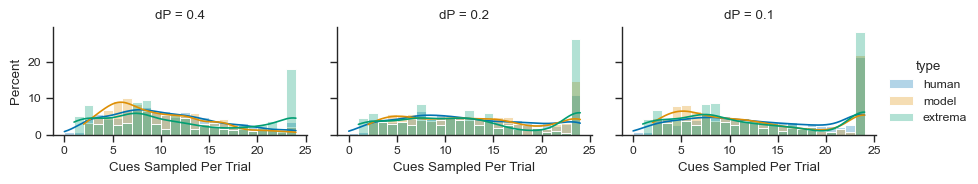

In [57]:
# plot_RTs("fiedler_trial_may8b", "fiedler_trial", "extrema_trial_fit", max_cues=12, aggregate=True)

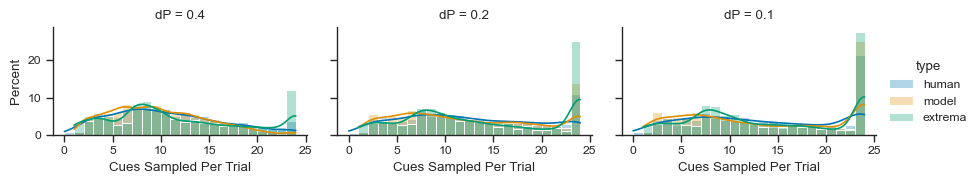

In [11]:
plot_RTs("fiedler_rerun_july12", "fiedler_trial", "extrema_trial_fit", max_cues=12, aggregate=True)

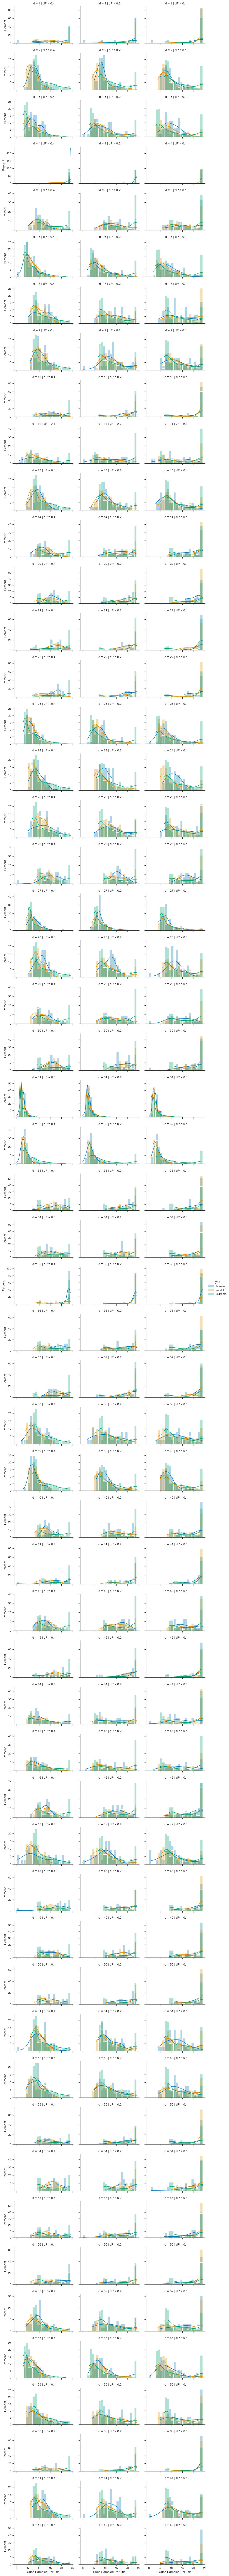

In [14]:
plot_RTs("fiedler_rerun_july12", "fiedler_trial", "july11extrema_fit", max_cues=12, aggregate=False)

### Replot specific participants

In [52]:
def plot_id_RTs(ids, simfile, empfile, extrfile, max_cues=12, bw=1, cut=0):
    emp = pd.read_pickle(f"data/{empfile}.pkl").query("max_cues==@max_cues")
    sim = pd.read_pickle(f"data/{simfile}.pkl").query("max_cues==@max_cues")
    extr = pd.read_pickle(f"data/{extrfile}.pkl").query("max_cues==@max_cues")
    # combined = pd.concat([emp, sim], ignore_index=True)
    # combined = pd.concat([emp, sim, extr], ignore_index=True)
    # combined = combined.astype({"id": int})
    # bins = np.arange(0, 2*max_cues+cue_step, cue_step)
    # fig = sns.FacetGrid(combined.query("id in @pids"), row="id", col="dP", hue='type',
    #                     row_order=pids, col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1.5)
    # fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", bins=bins, common_norm=False, alpha=0.3)
    # fig.set_xlabels("Cues Sampled Per Trial")
    # fig.add_legend()
    # fig.savefig(f"plots/fiedler_exemplars_RTs.svg")
    # fig.savefig(f"plots/fiedler_exemplars_RTs.png")


    # emp = pd.read_pickle(f"data/fiedler_trial.pkl").query("max_cues==@max_cues")
    # sim = pd.read_pickle(f"data/fiedler_trial_may8b.pkl").query("max_cues==@max_cues")
    # sim = pd.read_pickle(f"data/fiedler_trial_june26.pkl").query("max_cues==@max_cues")
    eval_points = np.linspace(0, 2*max_cues, 1000)
    
    strids = [str(pid) for pid in ids]
    # combined = pd.concat([emp.query("id in @ids"), sim.query("id in @strids")], ignore_index=True)
    # combined = pd.concat([emp.query("id in @ids"), sim.query("id in @strids"), extr.query("id in @ids")], ignore_index=True)
    # combined = combined.astype({"id": int})
    
    fig, axes = plt.subplots(nrows=len(ids), ncols=3, figsize=((7, 2*len(ids))), sharey='row', sharex=True)
    for i, pid in enumerate(ids):
        strpid = str(pid)
        for p, dP in enumerate([0.4, 0.2, 0.1]):
            difficulty = ['Easy', 'Moderate', 'Hard'][p]
            cues_emp = emp.query("id==@pid & dP==@dP")['cues'].to_numpy()
            # cues_sim = sim.query("id==@strpid & dP==@dP")['cues'].to_numpy()
            cues_sim = sim.query("id==@pid & dP==@dP")['cues'].to_numpy()
            cues_extr = extr.query("id==@pid & dP==@dP")['cues'].to_numpy()
            sns.histplot(cues_emp, stat='percent', bins=np.arange(0, 2*max_cues+1, 1), common_norm=False, ax=axes[i][p], color=palette[0], label=f'Human #{pid}')
            sns.histplot(cues_sim, stat='percent', bins=np.arange(0, 2*max_cues+1, 1), common_norm=False, ax=axes[i][p], color=palette[1], label=f'Model #{pid}')
            # sns.histplot(cues_extr, stat='percent', bins=np.arange(0, 2*max_cues+1, 1), common_norm=False, ax=axes[i][p], color=palette[2])
            unique_emp = emp.query("id==@pid & dP==@dP")['cues'].unique()
            # unique_sim = sim.query("id==@strpid & dP==@dP")['cues'].unique()
            unique_sim = sim.query("id==@pid & dP==@dP")['cues'].unique()
            unique_extr = extr.query("id==@pid & dP==@dP")['cues'].unique()
            emp_acc = 100 * emp.query("id==@pid & dP==@dP")['accuracy'].mean()
            # sim_acc = sim.query("id==@strpid & dP==@dP")['accuracy'].mean()
            sim_acc = sim.query("id==@pid & dP==@dP")['accuracy'].mean()
            extr_acc = extr.query("id==@pid & dP==@dP")['accuracy'].mean()
            if len(unique_sim)==1 or len(unique_emp)==1:
                mean_emp = np.mean(cues_emp)
                mean_sim = np.mean(cues_sim)
                error = np.abs(mean_emp - mean_sim)
            else:
                kde_emp = gaussian_kde(cues_emp, bw_method='scott')
                kde_sim = gaussian_kde(cues_sim, bw_method='scott')
                kde_extr = gaussian_kde(cues_extr, bw_method='scott')
                estimate_emp = kde_emp.evaluate(eval_points)
                estimate_sim = kde_sim.evaluate(eval_points)
                estimate_extr = kde_extr.evaluate(eval_points)
                estimate_emp = 7000*estimate_emp / np.sum(estimate_emp)
                estimate_sim = 7000*estimate_sim / np.sum(estimate_sim)
                estimate_extr = 7000*estimate_extr / np.sum(estimate_extr)
                sns.lineplot(x=eval_points, y=estimate_emp, ax=axes[i][p])  # , label=f'acc={emp_acc:.0f}% (human #{pid})', color=palette[0])
                sns.lineplot(x=eval_points, y=estimate_sim, ax=axes[i][p])  # , label=f'acc={sim_acc:.0f}% (model)', color=palette[1])
                # sns.lineplot(x=eval_points, y=estimate_extr, ax=axes[i][p])  # , label=f'acc={extr_acc:.0f}% (extrema)', color=palette[2])
                # sns.lineplot(x=eval_points, y=100*estimate_sim, ax=axes[i][p], label=text_label, color=palette[1])
                # error = 1000*np.sqrt(np.mean(np.square(estimate_emp - estimate_sim)))
            # axes[i][p].set(title=f"id = {pid} | {difficulty}")  # error={error:.3}, , emp_acc={emp_acc:.3}, sim_acc={sim_acc:.3}
            # axes[i][p].set_title(f"id={pid}, {difficulty}", weight='bold' if p!=1 else None)  # error={error:.3}, , emp_acc={emp_acc:.3}, sim_acc={sim_acc:.3}
            # axes[i][p].legend(loc='upper center')
            # axes[i][p].spines['top'].set_visible(False)
            # axes[i][p].spines['right'].set_visible(False)
            axes[i][p].legend(loc='upper center')
            if p!=1:
                axes[i][p].set_facecolor('lightgray')

    for p, dP in enumerate([0.4, 0.2, 0.1]):
        for i, pid in enumerate(ids):
            if p!=1:
                axes[i][p].get_legend().remove()

    for pid_type in ['human', 'model', 'extrema']:
        for p, dP in enumerate([0.4, 0.2, 0.1]):
            for i, pid in enumerate(ids):
                emp_acc = 100 * emp.query("id==@pid & dP==@dP")['accuracy'].mean()
                sim_acc = sim.query("id==@pid & dP==@dP")['accuracy'].mean()
                extr_acc = extr.query("id==@pid & dP==@dP")['accuracy'].mean()
                if pid_type=='human': acc = emp_acc
                if pid_type=='model': acc = sim_acc
                if pid_type=='extrema': acc = extr_acc
                print(f"{pid_type} {pid} {dP} {acc:.1f}")
                    
    
    axes[0][0].set(title=f"Easy")
    axes[0][1].set(title=f"Normal")
    axes[0][2].set(title=f"Hard")
    axes[len(ids)-1][0].set(xlabel="Cues Sampled")
    axes[len(ids)-1][1].set(xlabel="Cues Sampled")
    axes[len(ids)-1][2].set(xlabel="Cues Sampled")
    axes[0][0].set(xticks=[0,6,12,18,24])
    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/fiedler_extremes.svg")
    fig.savefig(f"plots/fiedler_extremes.png", dpi=600)

human 6 0.4 93.2
human 61 0.4 100.0
human 43 0.4 100.0
human 6 0.2 77.2
human 61 0.2 97.3
human 43 0.2 95.0
human 6 0.1 59.3
human 61 0.1 80.6
human 43 0.1 80.0
model 6 0.4 91.3
model 61 0.4 96.9
model 43 0.4 100.0
model 6 0.2 79.4
model 61 0.2 89.3
model 43 0.2 95.8
model 6 0.1 64.5
model 61 0.1 72.8
model 43 0.1 87.6
extrema 6 0.4 89.6
extrema 61 0.4 97.0
extrema 43 0.4 98.3
extrema 6 0.2 76.4
extrema 61 0.2 80.5
extrema 43 0.2 83.5
extrema 6 0.1 60.9
extrema 61 0.1 65.8
extrema 43 0.1 62.7


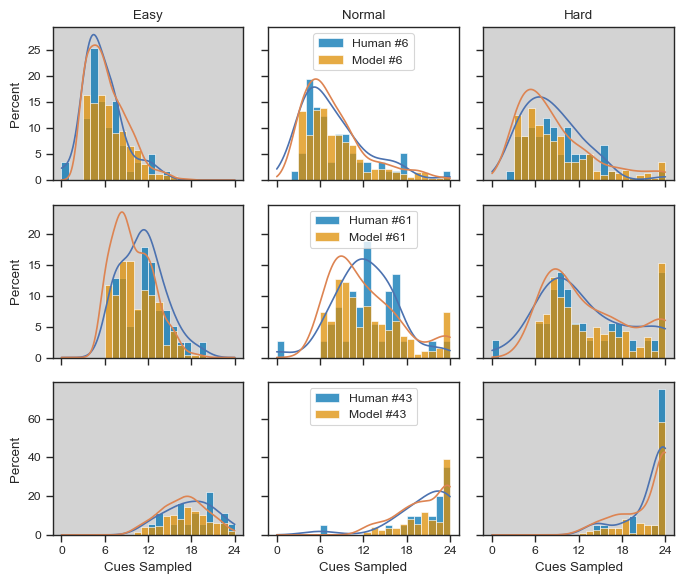

In [53]:
plot_id_RTs([6, 61, 43], "fiedler_rerun_july12", "fiedler_trial", "july11extrema_fit")

# Plot SAT and Efficiency Curves

In [18]:
def compute_sat(simfile, empfile, extrfile, label, scale_model=1, scale_extrema=1):
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([emp, sim, extr], ignore_index=True)   
    combined = combined.astype({"id": int})
    difficulties = ["easy", "moderate", "hard"]
    dfs = []
    dfs2 = []
    columns = ['type', 'id', 'difficulty', 'max_cues', 'mean cues', 'mean acc', 'nTrials', 'nCorrect']
    columns2 = ['type', 'id', 'difficulty', 'max_cues', 'mean cues', 'dependent_var', 'value']
    for id_type in combined['type'].unique():
        for pid in combined['id'].unique():
            for i, dP in enumerate(combined['dP'].unique()):
                for max_cues in combined['max_cues'].unique():
                    data = combined.query("type==@id_type & id==@pid & dP==@dP & max_cues==@max_cues")
                    mean_cues = data['cues'].mean()
                    mean_acc = data['accuracy'].mean()
                    if id_type=='human':
                        mean_acc *= 100
                    if id_type=='human':
                        nTrials = len(data['trial'].unique())
                        nCorrect = len(data.query("accuracy==1")['trial'].unique())                        
                    elif id_type=='model':
                        nTrials = len(data['trial'].unique()) * scale_model
                        nCorrect = len(data.query("accuracy==100")['trial'].unique()) * scale_model
                    elif id_type=='extrema':
                        nTrials = len(data['trial'].unique()) * scale_extrema
                        nCorrect = len(data.query("accuracy==100")['trial'].unique()) * scale_extrema
                    difficulty = difficulties[i]
                    dfs.append(pd.DataFrame([[id_type, pid, difficulty, max_cues, mean_cues, mean_acc, nTrials, nCorrect]], columns=columns))
                    dfs2.append(pd.DataFrame([[id_type, pid, difficulty, max_cues, mean_cues, "mean_acc", mean_acc]], columns=columns2))
                    dfs2.append(pd.DataFrame([[id_type, pid, difficulty, max_cues, mean_cues, "nTrials", nTrials]], columns=columns2))
                    dfs2.append(pd.DataFrame([[id_type, pid, difficulty, max_cues, mean_cues, "nCorrect", nCorrect]], columns=columns2))
    collapsed = pd.concat(dfs, ignore_index=True)
    collapsed2 = pd.concat(dfs2, ignore_index=True)
    collapsed.to_pickle(f"data/{label}.pkl")
    collapsed2.to_pickle(f"data/{label}2.pkl")

In [21]:
def plot_SAT(satfile, order=1, max_cues=[12,18], s=10):
    data = pd.read_pickle(f"data/{satfile}.pkl").query("max_cues in @max_cues")
    difficulties = ["easy", "moderate", "hard"]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7, 2), sharex=True, sharey=True)
    sns.scatterplot(data.query("difficulty=='easy'"), x='mean cues', y='mean acc', hue='type', s=s, ax=axes[0], palette=palette[:3])
    sns.scatterplot(data.query("difficulty=='moderate'"), x='mean cues', y='mean acc', hue='type', s=s, ax=axes[1], palette=palette[:3])
    sns.scatterplot(data.query("difficulty=='hard'"), x='mean cues', y='mean acc', hue='type', s=s, ax=axes[2], palette=palette[:3])
    axes[0].set(xlabel="Mean Cues", ylabel='Mean Accuracy', title='Easy', xticks=[0,5,10,15,20,25], yticks=[50, 60, 70, 80, 90, 100], ylim=[50, 105])
    axes[1].set(xlabel="Mean Cues", title='Moderate')
    axes[2].set(xlabel="Mean Cues", title='Hard')
    axes[0].legend()
    axes[1].get_legend().remove()
    axes[2].get_legend().remove()
    # axes[0].spines['top'].set_visible(False)
    # axes[0].spines['right'].set_visible(False)
    # axes[1].spines['top'].set_visible(False)
    # axes[1].spines['right'].set_visible(False)
    # axes[2].spines['top'].set_visible(False)
    # axes[2].spines['right'].set_visible(False)
    plt.tight_layout()
    fig.savefig(f"plots/fiedler_SAT.svg")
    fig.savefig(f"plots/fiedler_SAT.png", dpi=600)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7, 2), sharex=True, sharey=True)
    sns.scatterplot(data.query("difficulty=='easy'"), x='mean cues', y='nTrials', hue='type', s=s, ax=axes[0], palette=palette[:3])
    sns.scatterplot(data.query("difficulty=='moderate'"), x='mean cues', y='nTrials', hue='type', s=s, ax=axes[1], palette=palette[:3])
    sns.scatterplot(data.query("difficulty=='hard'"), x='mean cues', y='nTrials', hue='type', s=s, ax=axes[2], palette=palette[:3])
    axes[0].set(xlabel="Mean Cues", ylabel='Total Trials', title='Easy')
    axes[1].set(xlabel="Mean Cues", title='Moderate')
    axes[2].set(xlabel="Mean Cues", title='Hard')
    axes[0].legend()
    axes[1].get_legend().remove()
    axes[2].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/fiedler_total_trials.svg")
    fig.savefig(f"plots/fiedler_total_trials.png", dpi=600)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7, 2), sharex=True, sharey=True)
    sns.scatterplot(data.query("difficulty=='easy'"), x='mean cues', y='nCorrect', hue='type', s=s, ax=axes[0], palette=palette[:3])
    sns.scatterplot(data.query("difficulty=='moderate'"), x='mean cues', y='nCorrect', hue='type', s=s, ax=axes[1], palette=palette[:3])
    sns.scatterplot(data.query("difficulty=='hard'"), x='mean cues', y='nCorrect', hue='type', s=s, ax=axes[2], palette=palette[:3])
    axes[0].set(xlabel="Mean Cues", ylabel='Correct Trials', title='Easy', xticks=[0,5,10,15,20,25], yticks=[0, 50, 100, 150])
    axes[1].set(xlabel="Mean Cues", title='Moderate')
    axes[2].set(xlabel="Mean Cues", title='Hard')
    axes[0].legend()
    axes[1].get_legend().remove()
    axes[2].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/fiedler_correct_trials.svg")
    fig.savefig(f"plots/fiedler_correct_trials.png", dpi=600)

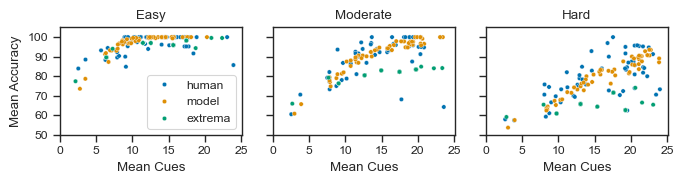

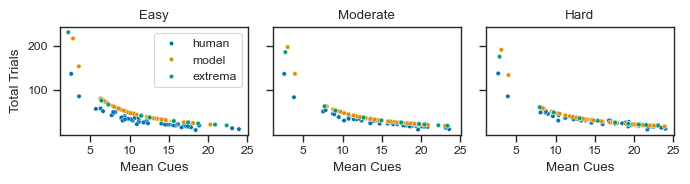

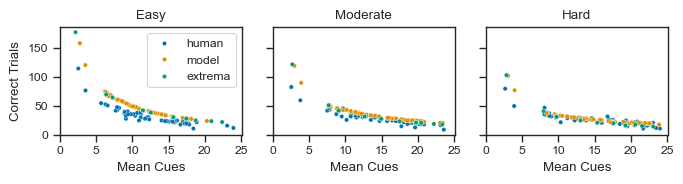

In [22]:
label = "july12"
compute_sat("fiedler_rerun_july12", "fiedler_trial", "july11extrema_fit", label, scale_model=0.2, scale_extrema=0.1)
plot_SAT(label, order=1, max_cues=[12])

## Statistics

In [13]:
def regress_SAT(satfile, max_cues=12, difficulties=["easy", "moderate", "hard"]):
    types = ['human', 'model']
    data = pd.read_pickle(f"data/{satfile}.pkl").query("max_cues==@max_cues").query("type in @types")
    # print(data)
    for difficulty in difficulties:
        x = data.query("difficulty==@difficulty & type=='human'")['mean cues'].to_numpy()
        y = data.query("difficulty==@difficulty & type=='human'")['mean acc'].to_numpy()
        x2 = data.query("difficulty==@difficulty & type=='model'")['mean cues'].to_numpy()
        y2 = data.query("difficulty==@difficulty & type=='model'")['mean acc'].to_numpy()
        res_human = linregress(x, y)
        res_agent = linregress(x2, y2)
        print(difficulty)
        print("human", res_human)
        print("agent", res_agent)
        print(ancova(data=data.query("difficulty==@difficulty"), dv='mean acc', covar='mean cues', between='type'))

In [14]:
# label = "july12"
# compute_sat("fiedler_rerun_july12", "fiedler_trial", "july11extrema_fit", label, scale_model=0.2, scale_extrema=0.1)
regress_SAT(label)

easy
human LinregressResult(slope=0.3660665086145139, intercept=92.15039257649335, rvalue=0.36706189865250183, pvalue=0.005840216460203965, stderr=0.1274258282871114, intercept_stderr=1.706247345391475)
agent LinregressResult(slope=1.010706966638316, intercept=85.64201056140874, rvalue=0.7475709939097257, pvalue=5.486342738538955e-11, stderr=0.12334510662126713, intercept_stderr=1.4852683540408138)
      Source           SS   DF          F         p-unc       np2
0       type    36.979592    1   2.214605  1.396514e-01  0.020278
1  mean cues   749.373429    1  44.877883  1.009257e-09  0.295487
2   Residual  1786.692068  107        NaN           NaN       NaN
moderate
human LinregressResult(slope=1.1248845310811668, intercept=73.48951878911825, rvalue=0.565591522587319, pvalue=6.808935222289356e-06, stderr=0.2252970446375931, intercept_stderr=3.495980281961554)
agent LinregressResult(slope=1.6347124634596704, intercept=66.8445661564052, rvalue=0.9281257399152513, pvalue=2.109438714963161

## Errors (model vs extrema, full model vs reduced model)

In [18]:
def get_kde_loss2(simulated, empirical, max_cues=12):
    eval_points = np.linspace(0, 2*max_cues, 1000)
    cues_sim = simulated['cues'].to_numpy()
    cues_emp = empirical['cues'].to_numpy()
    # check for zero variance and assign error accordingly
    unique_sim = simulated['cues'].unique()
    unique_emp = empirical['cues'].unique()
    if len(unique_sim)==1 or len(unique_emp)==1:
        mean_emp = np.mean(cues_emp)
        mean_sim = np.mean(cues_sim)
        loss = np.abs(mean_emp - mean_sim)
    else:
        # assign error normally
        kde_emp = gaussian_kde(cues_emp, bw_method='scott')
        kde_sim = gaussian_kde(cues_sim, bw_method='scott')
        estimate_emp = kde_emp.evaluate(eval_points)
        estimate_sim = kde_sim.evaluate(eval_points)
        estimate_emp = estimate_emp / np.sum(estimate_emp)
        estimate_sim = estimate_sim / np.sum(estimate_sim)
        loss = 1000*np.sqrt(np.mean(np.square(estimate_emp - estimate_sim)))
    return loss

def get_acc_loss(simulated, empirical, max_cues=12):
    acc_sim = simulated['accuracy'].mean()
    acc_emp = empirical['accuracy'].mean()
    return np.abs(acc_sim - 100*acc_emp)

In [26]:
def print_errors_fiedler(simfile, empfile, extrfile, max_cues=12, by_difficulty=False):

    emp = pd.read_pickle(f"data/{empfile}.pkl").query("max_cues==@max_cues")
    sim = pd.read_pickle(f"data/{simfile}.pkl").query("max_cues==@max_cues")
    extr = pd.read_pickle(f"data/{extrfile}.pkl").query("max_cues==@max_cues")
    emp = emp.astype({"id": int})
    sim = sim.astype({"id": int})
    extr = extr.astype({"id": int})

    if not by_difficulty:
        sim_kde_losses = []
        extr_kde_losses = []
        sim_acc_losses = []
        extr_acc_losses = []
    for dP in [0.4, 0.2, 0.1]:
        if by_difficulty:
            sim_kde_losses = []
            extr_kde_losses = []
            sim_acc_losses = []
            extr_acc_losses = []
        for pid in emp['id'].unique():
            sub_sim = sim.query("id==@pid & dP==@dP")
            sub_extr = extr.query("id==@pid & dP==@dP")
            sub_emp = emp.query("id==@pid & dP==@dP")
            # print(sub_sim)
            # print(sub_emp)
            # print(sub_extr)
            # raise
            sim_kde_losses.append(get_kde_loss2(sub_sim, sub_emp))
            extr_kde_losses.append(get_kde_loss2(sub_extr, sub_emp))
            sim_acc_losses.append(get_acc_loss(sub_sim, sub_emp))
            extr_acc_losses.append(get_acc_loss(sub_extr, sub_emp))
        if by_difficulty:
            print(f"{dP}, sim kde loss, {np.mean(sim_kde_losses):.3f}")
            print(f"{dP}, sim acc loss, {np.mean(sim_acc_losses):.3f}")
            print(f"{dP}, extr kde loss, {np.mean(extr_kde_losses):.3f}")
            print(f"{dP}, extr acc loss, {np.mean(extr_acc_losses):.3f}")
    
    if not by_difficulty:
        print(f"sim kde loss, {np.mean(sim_kde_losses):.3f}")
        print(f"sim acc loss, {np.mean(sim_acc_losses):.3f}")
        print(f"extr kde loss, {np.mean(extr_kde_losses):.3f}")
        print(f"extr acc loss, {np.mean(extr_acc_losses):.3f}")

In [24]:
print_errors_fiedler("fiedler_rerun_july12", "fiedler_trial", "july11extrema_fit")

sim kde loss, 0.488
sim acc loss, 4.733
extr kde loss, 0.738
extr acc loss, 9.254


In [28]:
print_errors_fiedler("fiedler_rerun_july12", "fiedler_trial", "fiedler_rerun_july12L0", by_difficulty=True)

0.4, sim kde loss, 0.663
0.4, sim acc loss, 2.442
0.4, extr kde loss, 0.732
0.4, extr acc loss, 2.825
0.2, sim kde loss, 0.288
0.2, sim acc loss, 4.652
0.2, extr kde loss, 0.364
0.2, extr acc loss, 4.453
0.1, sim kde loss, 0.512
0.1, sim acc loss, 7.106
0.1, extr kde loss, 0.463
0.1, extr acc loss, 7.598


In [30]:
paramfile = "fiedler_optimized_params_july11"
simfile = "fiedler_rerun_july12"
sim = pd.read_pickle(f"data/{simfile}.pkl").query("max_cues==12")
for pid in sim['id'].unique():
    with open(f"data/{paramfile}.json") as f:
        params = json.load(f)[str(pid)]
    # print(pid, params['ramp'], params['threshold_speed'], params['threshold_accuracy'], params['relative'], params['sigma'], params['dt_sample'])
    string1 = "4 & \ ref{fig.fiedler_sat}-\ ref{fig.fiedler_correct_trials} & "
    string2 = f"{pid} & ${params['ramp']:.2}$ & ${params['threshold']:.2}$ & ${params['relative']:.2}$ & - & - \ \ "
    print(string1+string2)

4 & \ ref{fig.fiedler_sat}-\ ref{fig.fiedler_correct_trials} & 1 & $2.0$ & $0.51$ & $0.8$ & - & - \ \ 
4 & \ ref{fig.fiedler_sat}-\ ref{fig.fiedler_correct_trials} & 2 & $2.4$ & $0.35$ & $0.47$ & - & - \ \ 
4 & \ ref{fig.fiedler_sat}-\ ref{fig.fiedler_correct_trials} & 3 & $1.5$ & $0.14$ & $0.92$ & - & - \ \ 
4 & \ ref{fig.fiedler_sat}-\ ref{fig.fiedler_correct_trials} & 4 & $2.5$ & $1.0$ & $0.44$ & - & - \ \ 
4 & \ ref{fig.fiedler_sat}-\ ref{fig.fiedler_correct_trials} & 5 & $1.5$ & $0.37$ & $0.49$ & - & - \ \ 
4 & \ ref{fig.fiedler_sat}-\ ref{fig.fiedler_correct_trials} & 6 & $2.6$ & $0.23$ & $0.89$ & - & - \ \ 
4 & \ ref{fig.fiedler_sat}-\ ref{fig.fiedler_correct_trials} & 7 & $2.9$ & $0.65$ & $0.4$ & - & - \ \ 
4 & \ ref{fig.fiedler_sat}-\ ref{fig.fiedler_correct_trials} & 9 & $2.3$ & $0.65$ & $0.07$ & - & - \ \ 
4 & \ ref{fig.fiedler_sat}-\ ref{fig.fiedler_correct_trials} & 10 & $1.8$ & $0.58$ & $0.64$ & - & - \ \ 
4 & \ ref{fig.fiedler_sat}-\ ref{fig.fiedler_correct_trials} & 11 

In [32]:
paramfile = "fiedler_optimized_params_july12L0"
simfile = "fiedler_rerun_july12"
sim = pd.read_pickle(f"data/{simfile}.pkl").query("max_cues==12")
for pid in sim['id'].unique():
    with open(f"data/{paramfile}.json") as f:
        params = json.load(f)[str(pid)]
    # print(pid, params['ramp'], params['threshold_speed'], params['threshold_accuracy'], params['relative'], params['sigma'], params['dt_sample'])
    string1 = "valuation & - & "
    string2 = f"{pid} & ${params['ramp']:.2}$ & ${params['threshold']:.2}$ & ${params['relative']:.2}$ & - & - \ \ "
    print(string1+string2)

valuation & - & 1 & $1.8$ & $0.85$ & $0.0$ & - & - \ \ 
valuation & - & 2 & $2.9$ & $0.54$ & $0.0$ & - & - \ \ 
valuation & - & 3 & $2.9$ & $0.54$ & $0.0$ & - & - \ \ 
valuation & - & 4 & $1.9$ & $1.0$ & $0.0$ & - & - \ \ 
valuation & - & 5 & $2.9$ & $0.86$ & $0.0$ & - & - \ \ 
valuation & - & 6 & $2.7$ & $0.46$ & $0.0$ & - & - \ \ 
valuation & - & 7 & $2.9$ & $0.84$ & $0.0$ & - & - \ \ 
valuation & - & 9 & $2.5$ & $0.72$ & $0.0$ & - & - \ \ 
valuation & - & 10 & $1.3$ & $0.7$ & $0.0$ & - & - \ \ 
valuation & - & 11 & $2.9$ & $0.78$ & $0.0$ & - & - \ \ 
valuation & - & 13 & $1.8$ & $0.39$ & $0.0$ & - & - \ \ 
valuation & - & 14 & $2.9$ & $0.97$ & $0.0$ & - & - \ \ 
valuation & - & 20 & $1.6$ & $0.77$ & $0.0$ & - & - \ \ 
valuation & - & 21 & $1.6$ & $0.79$ & $0.0$ & - & - \ \ 
valuation & - & 22 & $1.2$ & $0.65$ & $0.0$ & - & - \ \ 
valuation & - & 23 & $2.6$ & $0.44$ & $0.0$ & - & - \ \ 
valuation & - & 24 & $2.6$ & $0.51$ & $0.0$ & - & - \ \ 
valuation & - & 25 & $2.5$ & $0.74$ & $0.

# Misc

### Plot distribution of mean RTs and Accuracies across participants

In [116]:
def compute_means(simfile, empfile, extrfile):
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([emp, sim, extr], ignore_index=True)
    combined = combined.astype({"id": int})
    columns = ['type', 'id', 'difficulty', 'max_cues', 'mean_RT', 'mean_acc']
    dfs = []
    for id_type in combined['type'].unique():
        for pid in combined['id'].unique():
            for i, dP in enumerate([0.4, 0.2, 0.1]):
                for max_cues in [12, 18]:
                    data = combined.query("type==@id_type & id==@pid & dP==@dP & max_cues==@max_cues")
                    mean_RT = data['cues'].mean()
                    mean_acc = data['accuracy'].mean()
                    if id_type=='human':
                        mean_acc *= 100
                    difficulty = ['easy', 'moderate', 'hard'][i]
                    df = pd.DataFrame([[
                        id_type, pid, difficulty, max_cues, mean_RT, mean_acc
                        ]], columns=columns)
                    dfs.append(df)
    mean_data = pd.concat(dfs, ignore_index=True)
    mean_data.to_pickle("data/mean_data.pkl")

In [117]:
compute_means("fiedler_trial_may8b", "fiedler_trial", "extrema_trial_fit")

In [118]:
def plot_mean_distributions(meanfile, max_cues, cue_step=5):
    data = pd.read_pickle(f"data/{meanfile}.pkl").query("max_cues==@max_cues")

    bins = np.arange(0, 2*max_cues+cue_step, cue_step)
    fig = sns.FacetGrid(data, row=None, hue='type', col="difficulty", col_order=["easy", "moderate", "hard"], palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="mean_RT", stat='percent', element="poly", bins=bins, common_norm=False)
    fig.set_xlabels("Individual's Mean RT")
    fig.add_legend()
    fig.savefig(f"plots/fiedler_mean_RTs.svg")
    fig.savefig(f"plots/fiedler_mean_RTs.png", dpi=600)

    bins = np.arange(40, 110, 10)
    fig = sns.FacetGrid(data, row=None, hue='type', col="difficulty", col_order=["easy", "moderate", "hard"], palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="mean_acc", stat='percent', element="poly", bins=bins, common_norm=False)
    fig.set_xlabels("Individual's Mean Accuracy")
    fig.add_legend()
    fig.savefig(f"plots/fiedler_mean_accs.svg")
    fig.savefig(f"plots/fiedler_mean_accs.png", dpi=600)

In [25]:
# plot_mean_distributions("mean_data", max_cues=12)

In [26]:
# plot_mean_distributions("mean_data", max_cues=18)

### Plot Error Distributions
Compute the chi-squared distance between empirical and model/extrema distribution for each individual and each condition.

Compute the absolute difference in mean accuracy (across trials) for each individual and each condition.

Then plot the distribution of these two error metrics across individuals

In [121]:
def compute_RT_errors(simfile, empfile, extrfile, cue_step=5, aggregate=True):
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([emp, sim, extr], ignore_index=True)
    combined = combined.astype({"id": int})
    columns = ['type', 'id', 'difficulty', 'max_cues', 'chi2']
    dfs = []
    for model_type in ['model', 'extrema']:
        for pid in combined['id'].unique():
            for i, dP in enumerate([0.4, 0.2, 0.1]):
                for max_cues in [12, 18]:
                    bins = np.arange(0, 2*max_cues+cue_step, cue_step)
                    difficulty = ['easy', 'moderate', 'hard'][i]
                    empirical = combined.query("type=='human' & id==@pid & dP==@dP & max_cues==@max_cues")
                    simulated = combined.query("type==@model_type & id==@pid & dP==@dP & max_cues==@max_cues")
                    hist_empirical = np.histogram(empirical['cues'].to_numpy(), bins=bins)[0]
                    hist_simulated = np.histogram(simulated['cues'].to_numpy(), bins=bins)[0]
                    accs_empirical = empirical['accuracy'].to_numpy()
                    accs_simulated = simulated['accuracy'].to_numpy()
                    normed_empirical = hist_empirical / len(empirical)
                    normed_simulated = hist_simulated / len(simulated)
                    chi2 = chi_squared_distance(normed_empirical, normed_simulated)
                    df = pd.DataFrame([[
                        model_type, pid, difficulty, max_cues, chi2,
                        ]], columns=columns)
                    dfs.append(df)
    error_data = pd.concat(dfs, ignore_index=True)
    error_data.to_pickle("data/error_data.pkl")

In [122]:
compute_RT_errors("fiedler_trial_may8b", "fiedler_trial", "extrema_trial_fit", cue_step=5)

In [123]:
# pd.read_pickle("data/error_data.pkl")

In [124]:
def plot_error_distributions(errorfile):
    error = pd.read_pickle(f"data/{errorfile}.pkl")
    chi2_bins = np.arange(0, 1.1, 0.1)
    fig = sns.FacetGrid(error, row='max_cues', hue='type', col="difficulty", col_order=["easy", "moderate", "hard"], palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="chi2", stat='percent', element="poly", bins=chi2_bins, common_norm=False)
    fig.set_xlabels("Chi2 (human RT, model RT)")
    fig.add_legend()
    fig.savefig(f"plots/fiedler_RT_errors.svg")
    fig.savefig(f"plots/fiedler_RT_errors.png", dpi=600)

In [27]:
# plot_error_distributions("error_data")

In [ ]:
def plot_recency_bias(max_cues, aggregate=True):
    emp = pd.read_pickle(f"data/fiedler_binned.pkl").query("max_cues==@max_cues")
    if aggregate:
        fig = sns.FacetGrid(emp, col="difficulty", col_order=["easy", "moderate", "hard"], palette=palette, height=2, aspect=1.5)
        fig.map_dataframe(sns.regplot, x="fraction_sampled", y='mean_cue_choice_aligned', x_estimator=np.mean, order=2, scatter_kws={'s':10})
        fig.set_xlabels("Cue Position")
        fig.set_ylabels("P(sample $\simeq$ choice)")
        fig.set(xticks=np.arange(0, 1.2, 0.2), yticks=np.arange(0.0, 0.8, 0.1))
    else:
        fig = sns.FacetGrid(emp, row="id", col="difficulty", col_order=["easy", "moderate", "hard"], palette=palette, height=2, aspect=1.5)
        fig.map_dataframe(sns.regplot, x="fraction_sampled", y='mean_cue_choice_aligned', x_estimator=np.mean)

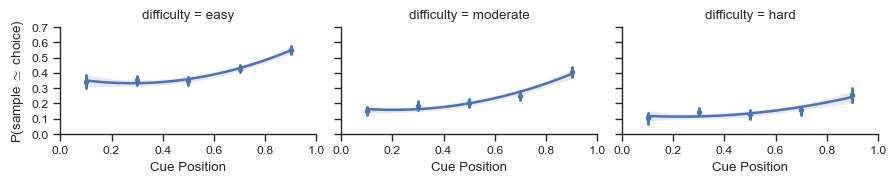

In [133]:
plot_recency_bias(max_cues=12)

In [9]:
def bin_and_average_by_fraction_sampled():
    extrema_position_fit = pd.read_pickle("data/extrema_position_fit.pkl")
    bins = np.arange(0.0, 1.2, 0.2)
    columns = ['type', 'tid', 'id', 'difficulty', 'max_cues', 'fraction_sampled', 'mean_cue_choice_aligned', 'std_cue_choice_aligned']
    dfs = []
    for pid in extrema_position_fit['id'].unique():
        tid = extrema_position_fit.query('id==@pid')['tid'].unique()[0]
        for difficulty in extrema_position_fit['difficulty'].unique():
            for max_cues in extrema_position_fit['max_cues'].unique():
                data = extrema_position_fit.query('id==@pid & difficulty==@difficulty & max_cues==@max_cues')
                for i in range(len(bins)-1):
                    left = bins[i]
                    right = bins[i+1]
                    midpoint = (left + right) / 2
                    cue_choices_aligned = data.query('fraction_sampled>@left & fraction_sampled<=@right')['cue_choice_aligned'].to_numpy()
                    if len(cue_choices_aligned)>1:
                        mean = np.mean(cue_choices_aligned)
                        std = np.std(cue_choices_aligned)
                    else:
                        mean = None
                        std = None
                    df = pd.DataFrame([[
                        'extrema', tid, pid, difficulty, max_cues, midpoint, mean, std,
                        ]], columns=columns)
                    dfs.append(df)
    extrema_binned_fit = pd.concat(dfs, ignore_index=True)
    extrema_binned_fit.to_pickle("data/extrema_binned_fit.pkl")  # each row contains average and std data from one participant in one condition

In [108]:
bin_and_average_by_fraction_sampled()

C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_14184\3079684321.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  extrema_binned_fit = pd.concat(dfs, ignore_index=True)


# Plot recency bias

In [10]:
def plot_recency_bias(simfile, empfile, extrfile, max_cues, facetgrid=False):
    emp = pd.read_pickle(f"data/{empfile}.pkl").query("max_cues==@max_cues")
    sim = pd.read_pickle(f"data/{simfile}.pkl").query("max_cues==@max_cues")
    extr = pd.read_pickle(f"data/{extrfile}.pkl").query("max_cues==@max_cues")
    combined = pd.concat([emp, sim, extr], ignore_index=True)
    if facetgrid:
        fig = sns.FacetGrid(combined, col="difficulty", col_order=["easy", "moderate", "hard"], hue='type', palette=palette, height=3, aspect=1)
        fig.map_dataframe(sns.regplot, x="fraction_sampled", y='mean_cue_choice_aligned', x_estimator=np.mean, order=2, x_jitter=1.0, scatter_kws={'s':10})
        fig.set_xlabels("Cue Position")
        fig.set_ylabels("P(sample $\simeq$ choice)")
        fig.add_legend()
        fig.set(xticks=np.arange(0, 1.2, 0.2), yticks=np.arange(0.0, 0.8, 0.1))
    else:
        fig = sns.lmplot(data=combined, x="fraction_sampled", y='mean_cue_choice_aligned', x_estimator=np.mean, order=2,
                         row=None, col="difficulty", hue='type', palette=palette, height=2.5, aspect=1, x_jitter=0.5, scatter_kws={'s':10})
        fig.set_xlabels("Cue Position")
        fig.set_ylabels("P(sample $\simeq$ choice)")
        fig.add_legend()
        fig.set(xticks=np.arange(0, 1.2, 0.2), yticks=np.arange(0.0, 0.8, 0.1))

    fig.savefig(f"plots/recency_bias.svg")
    fig.savefig(f"plots/recency_bias.png")

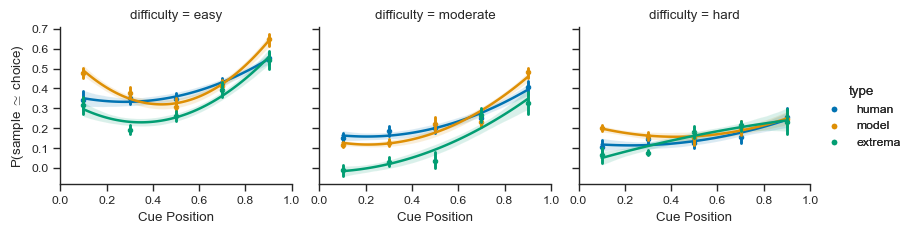

In [111]:
plot_recency_bias("fiedler_binned_may8b", "fiedler_binned", "extrema_binned_fit", max_cues=12)

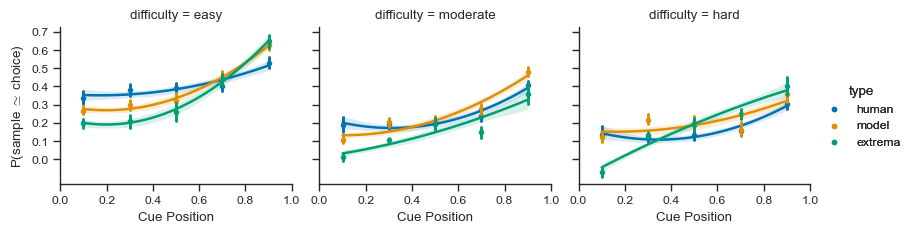

In [112]:
plot_recency_bias("fiedler_binned_may8b", "fiedler_binned", "extrema_binned_fit", max_cues=18)